In [39]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import imageio as iio
import matplotlib.pyplot as plt
from pmqd.torch import PMQD
from typing import Tuple
import itertools
import torchaudio.transforms as T
from pyramids import LaplacianPyramid
import torch.nn.functional as F
import conv as conv_utils
# from torchvision import datasets
# from torchvision.transforms import ToTensor

In [191]:
image = iio.v3.imread('lena.png')

In [192]:
image = image.mean(axis=-1)

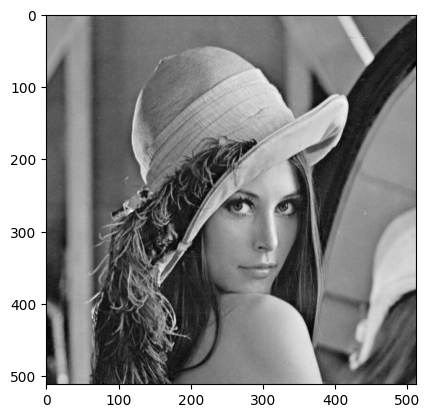

In [193]:
plt.imshow(image, cmap='gray')

In [28]:
dataset = PMQD(root="/Users/up20938/Coding/datasets/pmqd", download=False)
sample_rate = PMQD.SAMPLE_RATE

In [60]:
LAPLACIAN_FILTER = np.array([[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
                             [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
                             [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
                             [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
                             [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]],
                            dtype=np.float32)
filt = torch.from_numpy(np.reshape(np.tile(LAPLACIAN_FILTER, (1, 1, 1)), (1, 1, 5, 5)))

In [446]:
class LaplacianPyramid(nn.Module):
    def __init__(self, k, dims=3, filt_size=3, filt=None, trainable=False):
        super(LaplacianPyramid, self).__init__()
        if filt is None:
            filt = np.reshape(np.tile(LAPLACIAN_FILTER, (dims, 1, 1)),
                              (dims, 1, 5, 5))
        self.k = k
        self.trainable = trainable
        self.dims = dims
        self.filt_size = filt_size
        self.filt = nn.Parameter(torch.Tensor(filt), requires_grad=False)
        self.dn_filts, self.sigmas = self.DN_filters()

    """
    Spectrogram Filters
    """

    def DN_filters(self):
        sigmas = torch.tensor([1.19, 1.2, 1.22, 1.08, 0.92, 0.83]).reshape(6,1,1,1)
        dn_filts = torch.zeros(self.k,1,1,(self.filt_size**2)-1)
        # dn_filts.append(torch.zeros((1,1,24)))
        # dn_filts = dn_filts*self.k
        # dn_filts = nn.ParameterList([nn.Parameter(x, requires_grad=self.trainable)
        #                              for x in dn_filts])
        dn_filts = nn.Parameter(dn_filts, requires_grad=self.trainable)
        return dn_filts, sigmas

    def pyramid(self, im):
        abso = []
        J = im
        pyr = []
        for i in range(0, self.k):
            J_padding_amount = conv_utils.pad([J.size(2), J.size(3)],
                                              self.filt.size(3), stride=2)
            I = F.conv2d(F.pad(J, J_padding_amount, mode='reflect'), self.filt,
                         stride=2, padding=0, groups=self.dims)  # downsample and convolve
            I_up = F.interpolate(I, size=[J.size(2), J.size(3)],
                                 align_corners=True, mode='bilinear')  # upsample
            I_padding_amount = conv_utils.pad([I_up.size(2), I_up.size(3)],
                                              self.filt.size(3), stride=1)
            I_up_conv = F.conv2d(F.pad(I_up, I_padding_amount, mode='reflect'),  # convolve
                                 self.filt, stride=1, padding=0,
                                 groups=self.dims)
            out = J - I_up_conv  # z_k
            absolute = torch.abs(out)
            abso.append(absolute)
            out_padding_amount = conv_utils.pad(
                [out.size(2), out.size(3)], self.filt_size, stride=1)
            Lw =  np.insert(self.dn_filts[i],len(self.dn_filts[i])//2,0).reshape(1,1,self.filt_size,self.filt_size)
            out_conv = F.conv2d(
                F.pad(torch.abs(out), out_padding_amount, mode='reflect'),
               Lw,
                stride=1,
                groups=self.dims)
            out_norm = out / (self.sigmas[i]+out_conv) # y_k
            # print(out_norm.min(), out_norm.max())
            pyr.append(out_norm)

            J = I
        return (abso, pyr)

    def compare(self, x1, x2):
        y1 = self.pyramid(x1)
        y2 = self.pyramid(x2)
        total = []
        # Calculate difference in perceptual space (Tensors are stored
        # strangley to avoid needing to pad tensors)
        for z1, z2 in zip(y1, y2):
            diff = (z1 - z2) ** 2
            sqrt = torch.sqrt(torch.mean(diff, (1, 2, 3)))
            total.append(sqrt)
        return torch.norm(torch.stack(total), 0.6)

    def forward(self, neighbourhood, sigma):
        return (self.dn_filts.expand(-1, -1, neighbourhood.shape[1], -1) * neighbourhood).sum(-1).unsqueeze(-1) + sigma

In [400]:
def get_abs_value(im, k):
    sigmas = np.zeros((k))
    J = im
    for i in range(0, k):
        J_padding_amount = conv_utils.pad([J.size(2), J.size(3)], filt.size(3), stride=2)
        I = F.conv2d(F.pad(J, J_padding_amount, mode='reflect'), filt, stride=2, padding=0, groups=1)  # downsample and convolve
        I_up = F.interpolate(I, size=[J.size(2), J.size(3)], align_corners=True, mode='bilinear')  # upsample
        I_padding_amount = conv_utils.pad([I_up.size(2), I_up.size(3)], filt.size(3), stride=1)
        I_up_conv = F.conv2d(F.pad(I_up, I_padding_amount, mode='reflect'), filt, stride=1, padding=0, groups=1)  # convolve
        out = J - I_up_conv  # z_k
        abs_out = np.abs(out)
        sigmas[i] = abs_out.mean()
        J = I
    return sigmas

In [380]:
ndims = 3
image=torch.from_numpy(image)
pmd = LaplacianPyramid(ndims,dims=1)
pyr = pmd.pyramid(image.unsqueeze(0).unsqueeze(0).float())
image = pyr[0].squeeze(0).squeeze(0)

TypeError: expected np.ndarray (got Tensor)

In [381]:
reduced_sample_rate = 16050
window_size = 2048
hop_size = 64
num_mels = 512

In [382]:
transforms = nn.Sequential(
    T.Resample(orig_freq=sample_rate, new_freq=reduced_sample_rate),
    T.MelSpectrogram(
        n_mels=num_mels,
        n_fft=window_size,
        win_length=window_size,
        hop_length=hop_size,
        power=1,
        center=False,
        sample_rate=reduced_sample_rate,
        f_min=0,
        f_max=reduced_sample_rate / 2,
        window_fn=torch.hann_window
    ),
)

/Users/up20938/Coding/python/audio-pyramid/venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


In [383]:
class SpectrogramDatasetSigmas(Dataset):

    def __init__(self, dataset, transforms):
        self.data = dataset
        self.transforms = transforms

    def __len__(self):
        return 195 # 195 images per distortion type
        # return len(self.data)

    def __getitem__(self, idx):
        # convert from audio to spectrogram
        audio = self.data[idx]["audio"]
        mono = audio.mean(axis=0)
        image = self.transforms(mono).unsqueeze(0).unsqueeze(0)

        # extract sigmas
        sigmas = get_abs_value(image, 6)

        return sigmas

In [384]:
batch_size = 1

# Create data loaders.
sigma_data = SpectrogramDatasetSigmas(dataset,transforms=transforms)
sigma_dataloader = DataLoader(sigma_data, batch_size=batch_size)

sigmas = np.zeros((195,6))
for batch, s in enumerate(sigma_dataloader):
    sigmas[batch] = s
print(sigmas.mean(axis=0))

[1.19 1.2  1.22 1.08 0.92 0.83]


In [464]:
def get_pixel_neighbourhoods(image, filt_size):

    # image size
    h = image.shape[0]
    w = image.shape[1]

    # filter size MUST BE ODD
    fh = filt_size
    fw = filt_size

    # distance from edge of filter to centre of filter
    zh = ((fh+1)//2)-1
    zw = ((fw+1)//2)-1

    # border for non-padded images
    y=h-(2*zh)
    x=w-(2*zw)

    # pixel indices for all possible filter positions
    yy,xx=np.meshgrid(np.arange(y),np.arange(x))
    p = ((yy+zh)*(w)) + zw + (xx)
    p = p.T.flatten().reshape(-1,1)

    # neighbourhood indices around all possible pixels
    nh = np.tile(np.arange(-zh,fh-zh).reshape(-1,1),fw)*h
    nw = np.tile(np.arange(-zw,fw-zw).reshape(-1,1),fh).T
    h2 = (nh+nw).flatten()
    d = ((fw*fh)-1)//2
    mask = np.hstack((np.arange(d),np.arange(d)+d+1))
    hh = np.array([h2[mask]])
    n = p+hh


    # get pixel values from indices
    pixels = image.flatten()[p]
    neighbourhoods=image.flatten()[n]

    return neighbourhoods.unsqueeze(0), pixels.unsqueeze(0)

In [428]:
n, _ = get_pixel_neighbourhoods(image)
n.shape

TypeError: get_pixel_neighbourhoods() missing 1 required positional argument: 'filt_size'

In [474]:
class SpectrogramDataset(Dataset):

    def __init__(self, dataset, transforms):
        self.data = dataset
        self.transforms = transforms

    def __len__(self):
        return 195 # 195 images per distortion type
        # return len(self.data)

    def __getitem__(self, idx):
        # convert from audio to spectrogram
        audio = self.data[idx]["audio"]
        mono = audio.mean(axis=0)
        image = self.transforms(mono)

        # pass therough Laplacian Pyramid
        ndims = 6
        pmd = LaplacianPyramid(ndims,filt_size=5,dims=1)
        abso, pyr = pmd.pyramid(image.unsqueeze(0).unsqueeze(0).float())


        n_list = []
        p_list = []
        s_list = []

        for i in range(ndims):
            image = abso[i].squeeze(0).squeeze(0)

            # extract pixels and neighbourhoods
            neighbourhoods, pixels = get_pixel_neighbourhoods(image,filt_size=5)
            sigma = pmd.sigmas[i]
            n_list.append(neighbourhoods)
            p_list.append(pixels)
            s_list.append(sigma)

        return n_list, p_list, s_list

In [475]:
print(sigmas.mean(axis=0))

[1.19 1.2  1.22 1.08 0.92 0.83]


In [476]:
batch_size = 1

# Create data loaders.
train_data = SpectrogramDataset(dataset,transforms=transforms)
train_dataloader = DataLoader(train_data, batch_size=batch_size)
# test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y, s in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X[0].shape}")
    print(f"Shape of y: {y[0].shape} {y[0].dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 1, 518160, 24])
Shape of y: torch.Size([1, 1, 518160, 1]) torch.float32


In [448]:
class Filter(nn.Module):
    def __init__(self, fh,fw, batch_size):
        super ().__init__()
        self.filter = nn.Parameter(torch.zeros((batch_size,1,(fh*fw)-1)))

    def forward(self, neighbourhood):
        return (self.filter.expand(-1, neighbourhood.shape[1], -1) * neighbourhood).sum(-1).unsqueeze(-1)

In [477]:
device='cpu'
print(f"Using {device} device")

# model = Filter(5,5,batch_size=batch_size).to(device)
model = LaplacianPyramid(k=6,filt_size=5,trainable=True)
print(model)

Using cpu device
LaplacianPyramid()


In [478]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [479]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # prev_filter = torch.zeros((batch_size,1,8),requires_grad=True)
    model.train()
    for batch, (X, y, s) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        # print(X,y)

        losses = torch.tensor(0).float()

        # Compute prediction error
        for i in range(len(X)):
            pred = model(X[i],s[i])
            # print(pred[i].shape)
            # print(X[i].shape)

            """
            z_i is the pixel value estimated from the mean of its neighbours
            N_i means the neighbourhood
            """

            # loss is the difference between the absolute value and the dot product of the absolute value and weights plus sigma
            loss = loss_fn(pred[i].unsqueeze(0), y[i]).sum()
            losses += loss
        # print(pred, loss)
        loss = losses/len(X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.data.clamp_(0)

        # filter_d = prev_filter-model.filter
        # prev_filter = model.filter
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1)  # * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            for i in range(len(X)):
                print(f'filter {i}: \n{model.dn_filts[i].data}')
            # print(f'sum: \n{model.filter[0].sum().data}')

In [480]:
torch.set_printoptions(precision=4, threshold=None, edgeitems=None, linewidth=200, profile=None, sci_mode=False)
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 7.830526  [    1/  195]
filter 0: 
tensor([[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
          0.0010]]])
filter 1: 
tensor([[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
          0.0010]]])
filter 2: 
tensor([[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
          0.0010]]])
filter 3: 
tensor([[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
          0.0010]]])
filter 4: 
tensor([[[0.001

In [485]:
torch.set_printoptions(precision = 8)

In [486]:
model.dn_filts.data

tensor([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.15232396e-02,
           3.54153365e-01, 3.54284495e-01, 8.20538402e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00]]],


        [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           4.17492151e-01, 4.18497950e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00]]],


        [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0

In [ ]:
dn_filts = torch.tensor([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               8.15232396e-02, 3.54153365e-01, 0.00000000e+00, 3.54284495e-01, 8.20538402e-02,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],

            [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 4.17492151e-01, 0.00000000e+00, 4.18497950e-01, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],

            [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 4.03308600e-01, 0.00000000e+00, 4.04937327e-01, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],

            [[[0.00000000e+00, 0.00000000e+00, 1.80272770e-03, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 3.42956990e-01, 0.00000000e+00, 3.44613850e-01, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],

            [[[0.00000000e+00, 0.00000000e+00, 7.62450695e-02, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               4.72654792e-05, 1.49145573e-01, 0.00000000e+00, 1.53620824e-01, 3.48444119e-05,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 8.36522579e-02, 0.00000000e+00, 0.00000000e+00]]],

            [[[0.00000000e+00, 0.00000000e+00, 5.48025630e-02, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 8.64099056e-05, 1.37867581e-04, 0.00000000e+00, 6.32352458e-05,
               3.57608515e-04, 1.15041323e-02, 0.00000000e+00, 1.57447513e-02, 4.30504908e-04,
               5.56926061e-05, 5.07514887e-05, 1.43533718e-04, 6.86229760e-06, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 1.87745407e-01, 0.00000000e+00, 0.00000000e+00]]]])

In [264]:
np.insert(model.dn_filts[0].data.numpy(),12, 0).reshape(5,5)

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.  , 0.25, 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]], dtype=float32)

In [26]:
for batch, (x, y, s) in enumerate(train_dataloader):
    print(x.max(), x.min())

tensor(190.7634) tensor(0.)
tensor(126.4289) tensor(0.)
tensor(122.0338) tensor(0.)
tensor(10.3017) tensor(0.)
tensor(127.7253) tensor(0.)
tensor(102.6486) tensor(0.)
tensor(166.7818) tensor(0.)
tensor(117.4507) tensor(0.)
tensor(102.7321) tensor(0.)
tensor(113.4325) tensor(0.)
tensor(25.6201) tensor(0.)
tensor(153.9042) tensor(0.)
tensor(14.0984) tensor(0.)
tensor(38.2335) tensor(0.)
tensor(124.7063) tensor(0.)
tensor(110.1500) tensor(0.)
tensor(127.6029) tensor(0.)
tensor(173.2909) tensor(0.)
tensor(95.1236) tensor(0.)
tensor(218.8102) tensor(0.)
tensor(133.6782) tensor(0.)
tensor(136.3125) tensor(0.)
tensor(140.2728) tensor(0.)
tensor(134.1646) tensor(0.)
tensor(123.2827) tensor(0.)
tensor(82.5849) tensor(0.)
tensor(100.8339) tensor(0.)
tensor(93.5695) tensor(0.)
tensor(185.9773) tensor(0.)
tensor(90.8388) tensor(0.)
tensor(139.6511) tensor(0.)
tensor(143.7654) tensor(0.)
tensor(166.6629) tensor(0.)
tensor(233.0374) tensor(0.)
tensor(275.8803) tensor(0.)
tensor(118.7503) tensor(0.)


KeyboardInterrupt: 

In [14]:
sigmas = np.zeros(195)
for batch, (_, _, s) in enumerate(train_dataloader):
    sigmas[batch] = s
print(sigmas)
print(sigmas.mean())

[-3.37e-01 -1.69e-01 -7.56e-01  5.54e-01 -1.49e+00  3.53e-01 -1.14e-01
 -1.96e-01 -1.55e-01 -9.36e-02  8.11e-01 -2.04e-01 -5.62e-01  8.40e-01
 -1.46e-01 -2.70e-01 -2.58e-01 -3.56e-01 -2.68e-01 -6.13e-01 -1.08e-01
 -5.80e-02 -2.94e-01  4.13e+00 -2.27e-01  5.80e-02 -1.93e-01  2.43e+01
 -2.25e-01  3.43e-01 -2.27e-01 -5.69e-02  6.15e-01 -6.87e-01 -1.37e-01
  5.86e+00  2.63e+00 -3.40e+00  2.78e-01 -7.44e-01 -2.53e-01 -3.29e-01
 -2.43e-01 -1.73e-01 -5.88e-01 -1.47e-02 -1.83e-01 -6.69e-01 -1.77e-01
 -3.71e-01 -1.54e-01 -1.92e-01 -7.98e-02 -2.07e-01  3.81e-01 -6.41e-01
  2.37e-01 -2.97e-01 -1.56e-01  9.97e+01 -3.39e-01 -3.14e-01 -2.64e-01
  1.87e-01 -4.37e+00 -2.49e-01 -1.43e+00 -5.58e-01 -2.10e+00 -9.21e-01
 -2.86e-01  2.70e-01 -2.26e-01 -2.30e-01 -2.13e-01 -2.52e-01 -3.77e-01
 -2.01e+00 -1.20e-01 -1.21e+00 -1.77e-01  3.01e-01 -1.52e-01 -3.84e-02
 -5.66e-01 -2.53e-01  5.95e-01 -1.48e-02  9.83e-01 -4.29e-01 -1.92e-01
 -3.06e-01 -2.13e-01 -7.52e-01 -2.83e-01 -3.52e-01 -2.67e-01  1.17e+00
  1.57

In [26]:
class FilterLoss(nn.Module):

    def __init__(self) -> None:
        super(FilterLoss, self).__init__()

    def forward(self,
                pixel: torch.Tensor,
                neighbourhood: torch.Tensor,
                filt: torch.Tensor) -> torch.Tensor:

        # So for each pixel in some training set, you take the neighbourhood (and not the original pixel) and
        # do a dot product with the filter.

        print(neighbourhood.shape, filt.shape)
        print(f'neighbourhood:\n{neighbourhood}')

        print(f'filt:\n{filt}')
        product = torch.dot(neighbourhood, filt) # 1x8 x 8x1 = 1x1

        print(f'product:\n{product}')
        # You then try to find the filter that minimises the difference between this dot product and the original pixel value (according to the squared difference).
        print(f'pixel:\n{pixel}')
        difference = (pixel - product) ** 2

        print(f'difference:\n{difference}')
        loss = -difference

        print(f'loss:\n{loss}')
        # The sigma is then just the mean of absolute value at each stage.
        # MEAN ABSOLUTE VALUE OF PIXELS OR FILTER
        # print(f'sigma:\n{sigma}')
        # Valero thinks he restricted the filter values to be positive also. For the filters, it should just be a least squares solution.
        return loss

In [ ]:
trained_filter = torch.tensor([[[0.0654, 0.0636, 0.0649, 0.2984, 0.2985, 0.0648, 0.0636, 0.0654]]])

In [5]:
class TransformedPMQD(Dataset):
    """Transform the first channel of audio and return it together with the rating."""

    def __init__(self, dataset: PMQD, transforms: nn.Sequential):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
        example = self.dataset[n]
        # channel = example["audio"][0] # first channel
        channel = example["audio"].mean(axis=-1) # sum to mono
        # return self.transforms(channel), example["rating"]
        return self.transforms(channel), example

In [ ]:
dataloader = DataLoader(TransformedPMQD(dataset, transforms), batch_size=195)
omhn = []

for mel_spectrograms, rating in itertools.islice(dataloader, 0, 1):
    omhn.append(mel_spectrograms)

In [2]:
class PearsonCorrelation(nn.Module):
    """
    Module for measuring Pearson correlation.
    Given samples (x, y), the Pearson correlation coefficient is given by:
    .. math::
        r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
        {\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}
    """
    def __init__(self) -> None:
        super(PearsonCorrelation, self).__init__()

    def forward(self,
                x: torch.Tensor,
                y: torch.Tensor) -> torch.Tensor:
        """
        Performs Pearson Correlation calculation between ``score`` and ``mos``
        Parameters
        ----------
        x : torch.Tensor
            First input tensor.
        y : torch.Tensor
            Second input tensor.
        TODO: dimensions of the input data have to agree, have to be batch wise
              and check for NaN values in the result.
        Returns
        -------
        correlation : torch.Tensor
            Tensor containing correlations.
        """
        x_n = x - torch.mean(x)
        y_n = y - torch.mean(y)
        x_n_norm = torch.sqrt(torch.mean(x_n**2))
        y_n_norm = torch.sqrt(torch.mean(y_n**2))
        normaliser = x_n_norm * y_n_norm
        return -torch.mean(x_n*y_n.squeeze(), dim=0) / normaliser

In [3]:
class FilterLoss(nn.Module):

    def __init__(self) -> None:
        super(FilterLoss, self).__init__()

    def forward(self,
                image: torch.Tensor,
                filt: torch.Tensor) -> torch.Tensor:

        image = np.ones((128,256))*0.3

        #It's a regression problem where you want to predict the absolute value of the central pixel given the neighbours.
        # e.g pixel = 4,4
        # then neighbourhood = [(3,3),(3,4),(3,5),(4,3),(4,5),(5,3),(5,4),(5,5)]

        image_height = image.shape[0]
        image_width = image.shape[1]

        pixels = []
        neighbourhoods = []

        for i in range(1, image_height):
            if 0 < i < image_height-1: # don't choose pixels on border
                for j in range(image_width):
                    if 0 < j < image_width-1: # don't choose pixels on border
                        pixel = image[i,j]
                        neighbourhood = np.array([[image[i-1, j-1], image[i-1, j], image[i-1, j+1],
                                                   image[i, j-1],                  image[i, j+1],
                                                   image[i+1, j-1], image[i+1, j], image[i+1, j+1]]])
                        pixels.append(pixel)
                        neighbourhoods.append(neighbourhood)


        # So for each pixel in some training set, you take the neighbourhood (and not the original pixel) and
        # do a dot product with the filter.

        # filter = torch.zeros((1,3,3))
        filt = np.ones((8, 1))*0.5

        print(neighbourhood.shape, filt.shape)
        print(f'neighbourhood:\n{neighbourhood}')

        print(f'filt:\n{filt}')
        product = torch.dot(neighbourhood, filt) # 1x8 x 8x1 = 1x1

        print(f'product:\n{product}')
        # You then try to find the filter that minimises the difference between this dot product and the original pixel value (according to the squared difference).
        print(f'pixel:\n{pixel}')
        difference = (pixel - product) ** 2

        print(f'difference:\n{difference}')
        loss = -difference


        print(f'loss:\n{loss}')
        # The sigma is then just the mean of absolute value at each stage.
        # MEAN ABSOLUTE VALUE OF PIXELS OR FILTER
        # print(f'sigma:\n{sigma}')
        # Valero thinks he restricted the filter values to be positive also. For the filters, it should just be a least squares solution.
        return loss
